# Time-inhomogeneous coalescent

In [1]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

Indlæser krævet pakke: viridisLite



R header:

In [110]:
library(tidyverse)
library(devtools)
#remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")
library(ptdalgorithms)

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(size=17)
                # text=element_text(family="Arial")
                ) 


In [111]:
# remove.packages("ptdalgorithms")

In [112]:
# install.packages("remotes")
# remotes::install_github("Thell/RcppMP")

In [113]:
# # GNUMPLIB
# ./configure --prefix=$CONDA_PREFIX --enable-cxx


In [114]:
# !export LIBS="-L/Users/kmt/miniconda3/envs/phasetype/lib"
# !export CPPFLAGS="-I/Users/kmt/miniconda3/envs/phasetype/include"

In [115]:
# Rcpp::sourceCpp("./timeinhom-kingman.cpp")

In [2]:
source("plot_functions.R")

Warning message in file(filename, "r", encoding = encoding):
“kan ikke åbne fil './utils/plotting.R': No such file or directory”


ERROR: Error in file(filename, "r", encoding = encoding): kan ikke åbne forbindelsen


In [117]:
theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(family="Arial")
                )

## Generate state space in R

In [122]:
standard_coalescent <- function(n, size, graph=NULL, edge_trans=NULL, epoque=0) {

    state_vector_length <- n + 1

    if (is.null(graph)) {
    
        graph <- create_graph(state_vector_length)
        starting_vertex <- vertex_at(graph, 1)
        initial_state <- c(rep(0, n), epoque)
        initial_state[1] <- n
        
        add_edge(
          starting_vertex,
          create_vertex(graph, initial_state),
          1
        )
        index <- 2
        
    } else {
        nr_states <- vertices_length(graph)
        for (i in 2:(nr_states-1)) {
            if (is.nan(edge_trans[i-1])) {
                next;
            }
            vertex <- vertex_at(graph, i)
            state <- vertex$state
            sister_state <- state
            sister_state[length(sister_state)] <- epoque
            add_edge(
              vertex,
              find_or_create_vertex(graph, sister_state),
              edge_trans[i-1], c(edge_trans[i-1]) # -1 becuase first index is 2 and first element of edge_trans is 1
            )
        }
        index <- nr_states + 1
    }

    while (index <= vertices_length(graph)) {
      vertex <- vertex_at(graph, index)

        # loop over all classes of lineages
      for (i in 1:n) {
        for (j in i:n) {
          state <- vertex$state

          # if same class, there need to be at least two to coalesce
          if (i == j) {
            if (state[i] < 2) {
              next; # an absorbing state that is not the last state
            }
            # coal rate
            rate <- state[i] * (state[i] - 1) / 2
          } else {
            # else at least one in each class to coalesce
            if (state[i] < 1 || state[j] < 1) {
              next;
            }
            # number of combinations
            rate <- state[i] * state[j]
          }

          rate = rate / size
            
          # copy state
          child_state <- state
            
          # update child state
          child_state[i] <- child_state[i] - 1
          child_state[j] <- child_state[j] - 1
          child_state[i+j] <- child_state[i+j] + 1

          add_edge(
              vertex,
              find_or_create_vertex(graph, child_state),
              rate, c(rate)
            )
        }
      }
        
      index <- index + 1
    }
    if (epoque == 0) {
        return(graph)
    }
}

add_epoque <- function(n, size, graph, epoque_trans, epoque)
    return(standard_coalescent(n, size, graph, epoque_trans, epoque))

In [123]:
epoque_end <- 1
n_samples <- 2

In [124]:
graph <- standard_coalescent(n_samples, 1)
graph_as_matrix(graph)

$states
     [,1] [,2] [,3]
[1,]    2    0    0

$SIM
     [,1]
[1,]   -1

$IPV
[1] 1

$indices
[1] 2

In [125]:
stop_probability(graph, 1)
accumulated_visiting_time(graph, 1)

[1] 0.0000000 0.3676997 0.0000000

[1] 0.0000000 0.6326593 0.0000000

In [126]:
#moments(graph, 5)

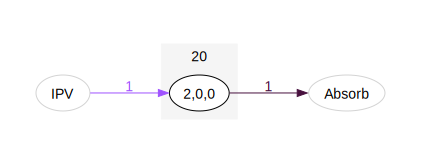

In [127]:
#plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, size=c(10, 10))

gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

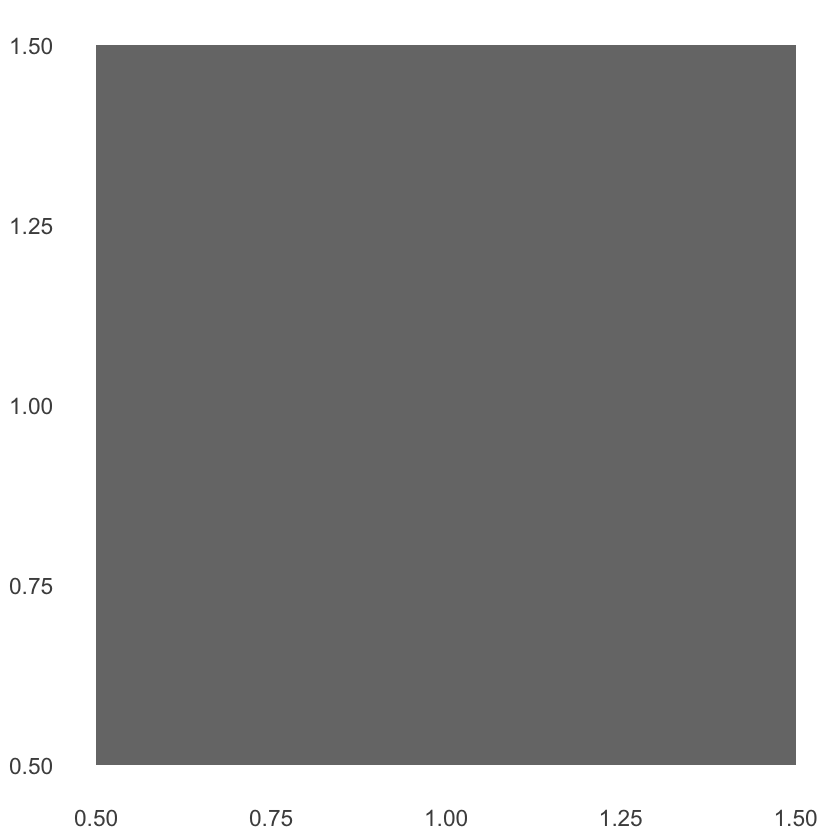

In [128]:
plot_sim(graph)

In [129]:
x <- stop_probability(graph, epoque_end)
stop_probs <- x[2:(length(x)-1)]
x <- accumulated_visiting_time(graph, epoque_end)
accum_v_time <- x[2:(length(x)-1)]
epoque_trans_rates <- stop_probs / accum_v_time
epoque_trans_rates

[1] 0.581197

In [130]:
add_epoque(n_samples, 5, graph, epoque_trans_rates, 1)
# add_epoque(n_samples, 10, graph, epoque_end, 1)
# graph_as_matrix(graph)

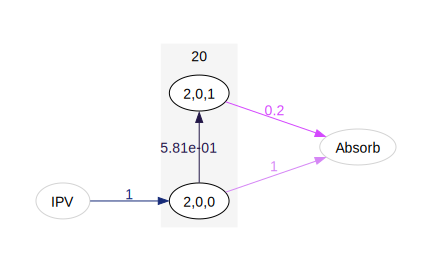

In [131]:
#plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, size=c(10, 10))

gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

In [133]:
stop_probability(graph, 1)
accumulated_visiting_time(graph, 1)

[1] 0.0000000 0.2054774 0.0000000 0.2580455 0.0000000

[1] 0.0000000 0.5026824 0.0000000 0.1702287 0.0000000

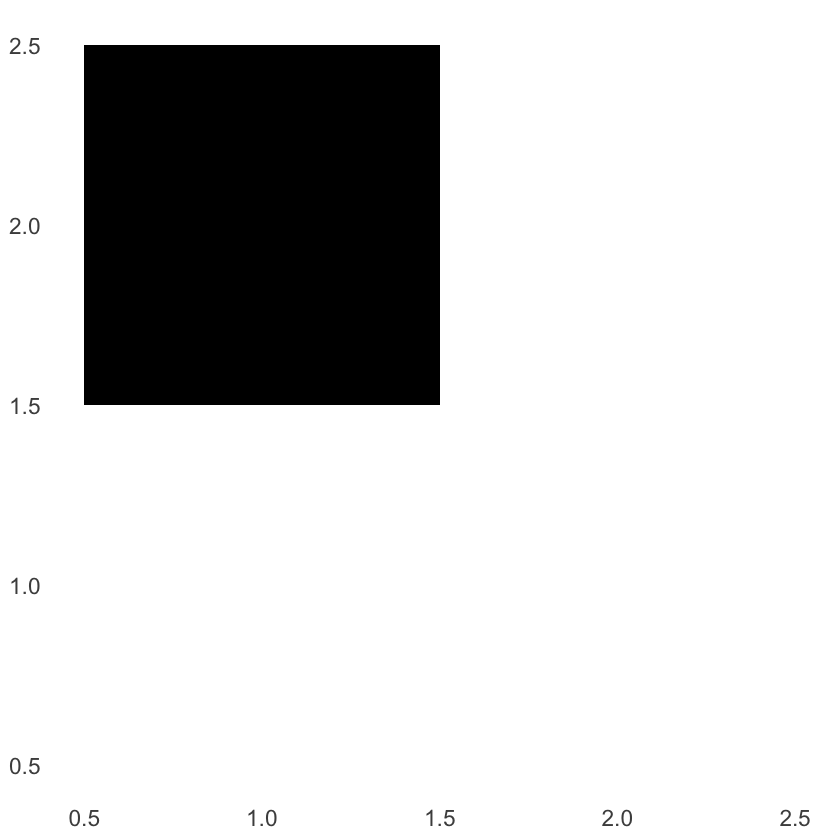

In [132]:
plot_sim(graph)

In [26]:
epoque_end <- 2
x <- stop_probability(graph, epoque_end)
stop_probs <- x[2:(length(x)-1)]
x <- accumulated_visiting_time(graph, epoque_end)
accum_v_time <- x[2:(length(x)-1)]
epoque_trans_rates <- stop_probs / accum_v_time
epoque_trans_rates

[1] 0.06969784        NaN 0.60194042

In [27]:
add_epoque(n_samples, 10, graph, epoque_trans_rates, 2)

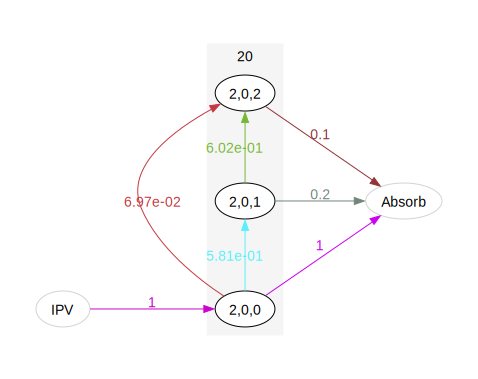

In [28]:
#plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, size=c(10, 10))

gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

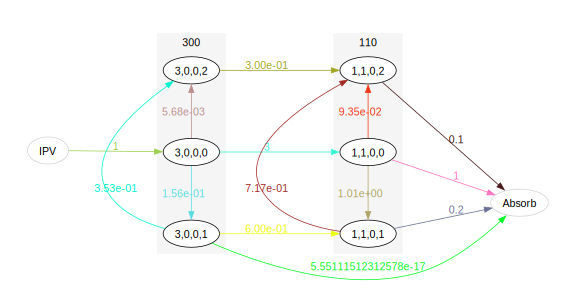

In [55]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

In [21]:
gam

2,0,0
2,0,1
2,0,2
-1.650895,0.5811970,0.06969784
0.000000,-0.8019404,0.60194042
0.000000,0.0000000,-0.10000000


In [31]:
#plot_sim(graph)

In [32]:
expectation(graph)

[1] 4.109414

In [33]:
moments(graph, 5)

[1] 4.109414e+00 7.395721e+01 2.199663e+03 8.791993e+04 4.395667e+06

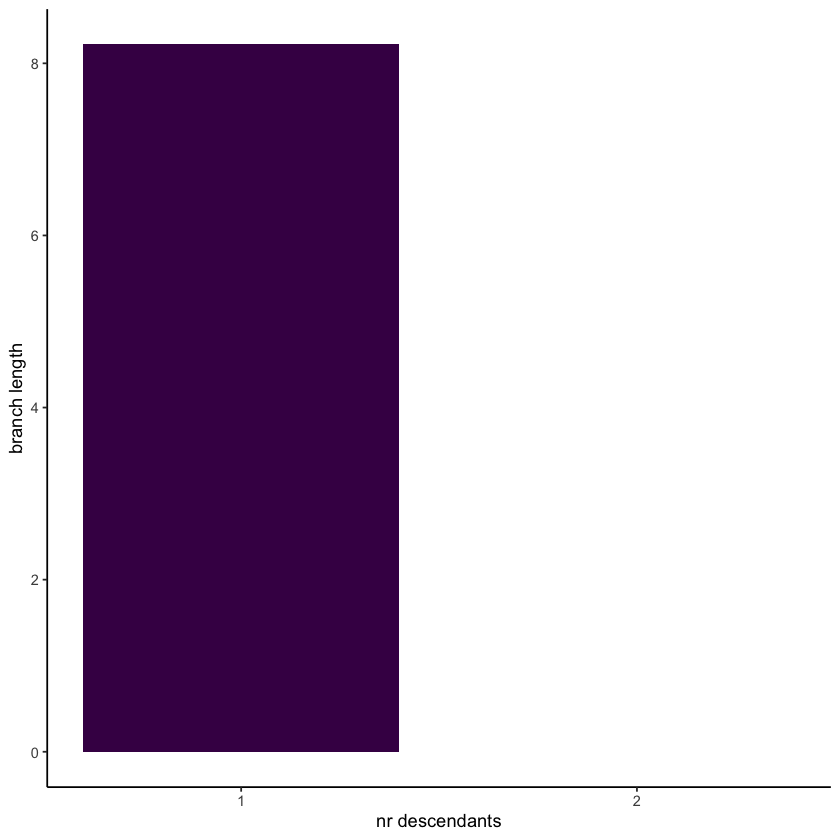

In [34]:
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

plot_sfs(graph, rewards) + labs(y = "branch length", x = "ton") +  scale_x_continuous(breaks = 1:9)+ theme(legend.position = "none") + labs(x='nr descendants')

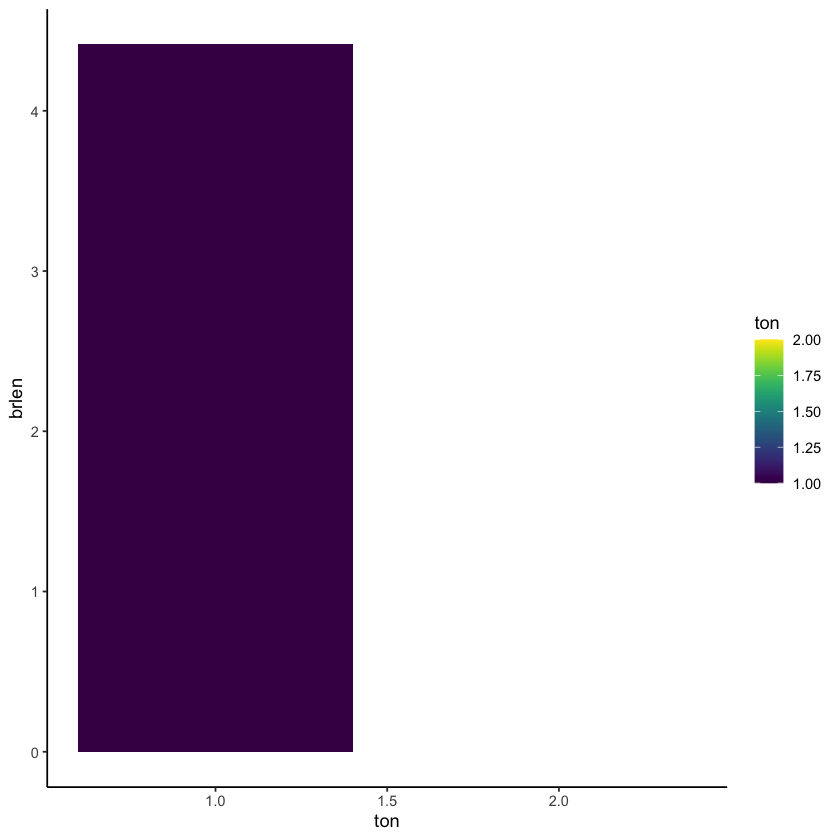

In [35]:
sizes <- c(1, 10)
epoques <- c(0, epoque_end)
distr_cont_graph <- standard_coalescent(n_samples, 1)
rewards <- sapply(1:vertices_length(distr_cont_graph), function(index) vertex_at(distr_cont_graph, index)$state )

tmrca_pdf <- c()
time <- c()

ctx <- distribution_context(distr_cont_graph, 1000)
prev_size <- 0
while (distribution_context_state(ctx)$cdf < 0.999) { 
    # tmrca_pdf <- c(tmrca_pdf, distribution_context_state(ctx)$pdf)
    # time <- c(time, distribution_context_state(ctx)$time)
    tmrca_pdf[[(length(tmrca_pdf) + 1)]] <- distribution_context_state(ctx)$pdf
    time[[(length(time) + 1)]] <- distribution_context_state(ctx)$time
    
    size <- sizes[findInterval(distribution_context_state(ctx)$time, epoques)]
    if (size != prev_size) {
        graph_update_weights_parameterized(distr_cont_graph, c(1/size))
    }
    prev_size <- size
    distribution_context_step(ctx)
}
expected_visits <- distribution_context_accumulated_visiting_time(ctx)
sfs <- c()
for (i in 1:(dim(rewards)[1]-1)) {
    sfs <- c(sfs, sum(expected_visits * rewards[i, ]))
}
data.frame(ton=seq(1,length(sfs)), brlen=sfs) %>%
ggplot(aes(x=ton, y=brlen, fill=ton)) + 
  geom_bar(stat = "identity", width=0.8) + scale_fill_viridis() + despine

In [36]:
n_samples <- 10

epoques <- c(0, 1, 2)
sizes <- c(1, 5, 10)

# epoques <- c(0)
# sizes <- c(1)

# epoques <- c(0, 1, 2)
# sizes <- c(1, 1, 1)

graph <- standard_coalescent(n_samples, sizes[1])
if (length(epoques) > 1) {
    for (i in 2:length(epoques)) {
        x <- stop_probability(graph, epoques[i])
        stop_probs <- x[2:(length(x)-1)]
        x <- accumulated_visiting_time(graph, epoques[i])
        accum_v_time <- x[2:(length(x)-1)]
        epoque_trans_rates <- stop_probs / accum_v_time
        add_epoque(n_samples, sizes[i], graph, epoque_trans_rates, i-1)
    }
}

In [37]:
mine <- moments(graph, 5)
print(paste(mine, collapse=', '))

[1] "8.82384323100548, 175.719893068682, 5304.45559566138, 212763.876309921, 10648555.4597396"


In [38]:
janek <- c(8.807791589074768, 177.8449395799212, 5388.12207361224, 216313.46645481227, 10829024.877199283)
(mine - janek) / janek

[1]  0.001822437 -0.011948873 -0.015527948 -0.016409474 -0.016665343

In [39]:
rewards <- sapply(1:vertices_length(graph), function(index) vertex_at(graph, index)$state )

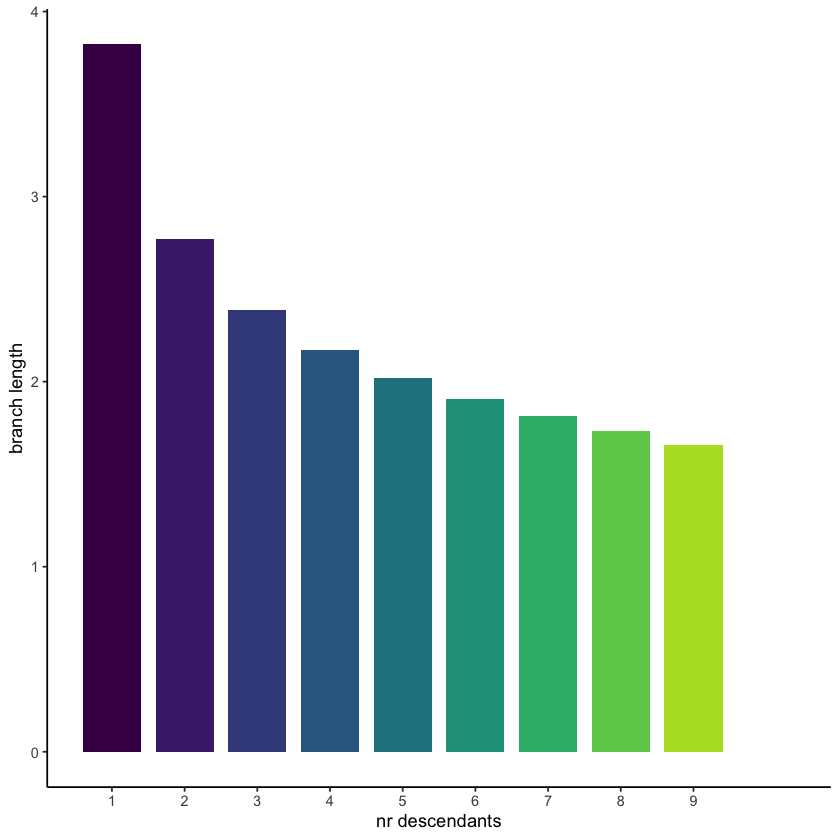

In [40]:
plot_sfs(graph, rewards) + labs(y = "branch length", x = "ton") +  scale_x_continuous(breaks = 1:(n_samples-1))+ theme(legend.position = "none") + labs(x='nr descendants')

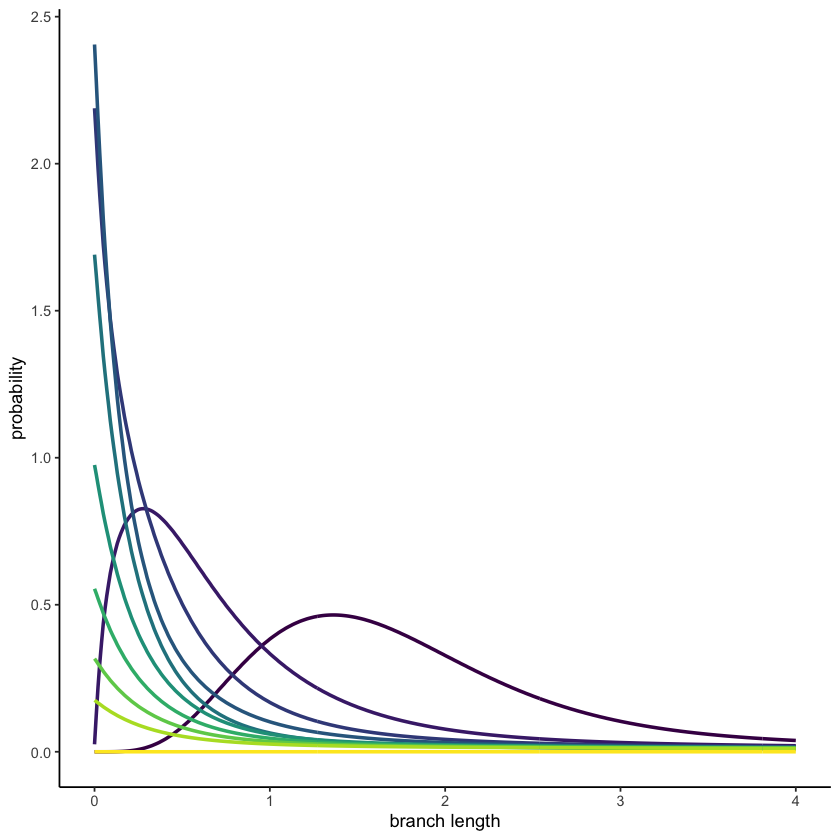

In [41]:
plot_sfs_dph(graph, rewards) + theme(legend.position = "none") + labs(x = "branch length")

In [42]:
# # https://cran.r-project.org/web/packages/PDQutils/vignettes/PDQutils.pdf
# install.packages("PDQutils")

In [43]:
# library(PDQutils)

# # compute moments and cumulants:
# df <- 5
# max.ord <- 20
# subords <- 0:(max.ord - 1)
# raw.cumulants <- df * (2^subords) * factorial(subords)
# raw.moments <- cumulant2moment(raw.cumulants)
# # compute the PDF of the rescaled variable:
# xvals <- seq(-sqrt(df/2) * 0.999, 6, length.out = 10001)
# chivals <- sqrt(2 * df) * xvals + df
# pdf.true <- sqrt(2 * df) * dchisq(chivals, df = df)
# pdf.gca2 <- sqrt(2 * df) * dapx_gca(chivals, raw.moments = raw.moments[1:2],
# support = c(0, Inf))
# pdf.gca6 <- sqrt(2 * df) * dapx_gca(chivals, raw.moments = raw.moments[1:6],
# support = c(0, Inf))
# all.pdf <- data.frame(x = xvals, true = pdf.true, gca2 = pdf.gca2,
# gca6 = pdf.gca6)
# # plot it by reshaping and ggplot'ing
# require(reshape2)
# arr.data <- melt(all.pdf, id.vars = "x", variable.name = "pdf",
# value.name = "density")
# require(ggplot2)
# ph <- ggplot(arr.data, aes(x = x, y = density, group = pdf,
# colour = pdf)) + geom_line()
# print(ph)

Compare this with the 2 and 4 term Edgeworth expansions

In [44]:
# # compute the PDF of the rescaled variable:
# xvals <- seq(-sqrt(df/2) * 0.99, 6, length.out = 1001)
# chivals <- sqrt(2 * df) * xvals + df
# pdf.true <- sqrt(2 * df) * dchisq(chivals, df = df)
# pdf.edgeworth2 <- sqrt(2 * df) * dapx_edgeworth(chivals,
# raw.cumulants = raw.cumulants[1:4], support = c(0,
# Inf))
# pdf.edgeworth4 <- sqrt(2 * df) * dapx_edgeworth(chivals,
# raw.cumulants = raw.cumulants[1:6], support = c(0,
# Inf))
# all.pdf <- data.frame(x = xvals, true = pdf.true, edgeworth2 = pdf.edgeworth2,
# edgeworth4 = pdf.edgeworth4)
# # plot it by reshaping and ggplot'ing
# require(reshape2)
# arr.data <- melt(all.pdf, id.vars = "x", variable.name = "pdf",
# value.name = "density")
# require(ggplot2)

## Generate state space in c

In [1]:
#library(plotly)
library(ggplot2)
library(viridis)
library(grid)
library(gridExtra)
library("IRdisplay")

library(tidyverse)
library(devtools)
remove.packages("ptdalgorithms")
# devtools::install_github("TobiasRoikjer/PtDAlgorithms")

#remove.packages("ptdalgorithms")
#devtools::install_github("kaspermunch/PtDAlgorithms")
devtools::install_local('../../PtDAlgorithms', quiet=FALSE)

library(ptdalgorithms)

source("plot_functions.R")

theme_set(theme_bw())

despine <- theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black"),
                # text=element_text(family="Arial")
                )

Indlæser krævet pakke: viridisLite

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.2     ✔ tibble    3.2.1
✔ purrr     1.0.1     ✔ tidyr     1.3.0
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::combine() masks gridExtra::combine()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Indlæser krævet pakke: usethis

Removing package from ‘/Users/kmt/miniconda3/envs/phasetype/lib/R/library’
(as ‘lib’ is unspecified)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done




── R CMD build ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
✔  checking for file ‘/private/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/RtmpTgcLwg/filef88b1c64f45c/PtDAlgorithms/DESCRIPTION’ (426ms)
─  preparing ‘ptdalgorithms’:
✔  checking DESCRIPTION meta-information
─  cleaning src
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
   Removed empty directory ‘ptdalgorithms/notebooks’
   Omitted ‘LazyData’ from DESCRIPTION
─  building ‘ptdalgorithms_1.0.0.tar.gz’
   


In [2]:
n_samples <- 2

In [3]:
Rcpp::sourceCpp("./timeinhom-kingman.cpp", 
                # verbose=TRUE,
                # rebuild = TRUE
               )

In [4]:
graph <- kingman_graph(n_samples, c(1))

In [5]:
stop_probability(graph, 1)

[1] 0.0000000 0.3676997 0.0000000

In [6]:
accumulated_visiting_time(graph, 1)

[1] 0.0000000 0.6326593 0.0000000

In [ ]:
add_epoque(graph, c(1/5), 1)
graph_as_matrix(graph)

In [22]:
# IF I CONVERT TO MATRIX AND BACK AGAIN, I GET THE RIGHT STOP PROBABILITIES.
# MAYBE BECAUSE MEMORY GETS REALLOCATED COVERING A MEMORY MISTAKE I MADE...
# gam <- graph_as_matrix(graph)
# graph <- matrix_as_graph(gam$IPV, gam$SIM)

In [23]:
stop_probability(graph, 1)

[1] 0.0000000 0.2054774 0.2580455 0.0000000

In [24]:
accumulated_visiting_time(graph, 1)

[1] 0.0000000 0.5026824 0.1702287 0.0000000

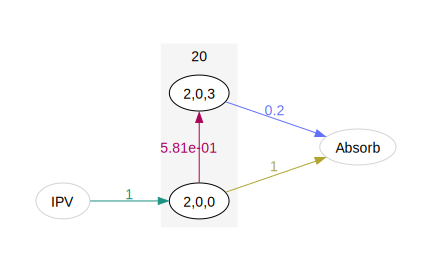

In [14]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

In [20]:
add_epoque(graph, c(1/10), 2)
graph_as_matrix(graph)

2,0,0
2,0,3
2,0,5
-1.737514,0.581197,0.156317
0.000000,NaN,NaN
0.000000,0.000000,-0.100000


In [ ]:
add_epoque(graph, c(100), 3)
add_epoque(graph, c(200), 4)
add_epoque(graph, c(300), 5)
add_epoque(graph, c(400), 6)
add_epoque(graph, c(500), 7)
graph_as_matrix(graph)

In [8]:
#plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, size=c(8, 8))
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))

ERROR: Error in if ((i != j) && (gam$SIM[i, j] > 0)) {: manglende værdi hvor TRUE/FALSE er krævet


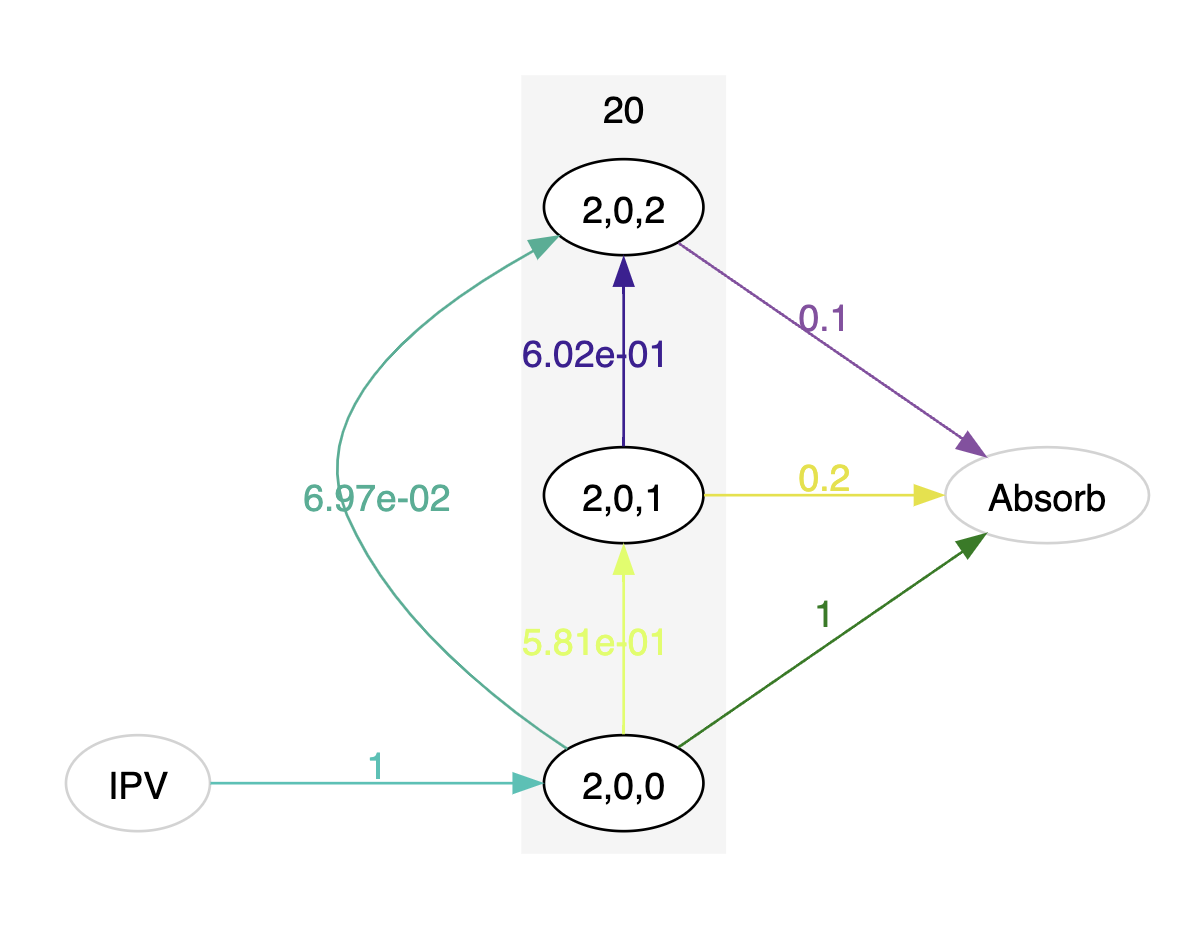

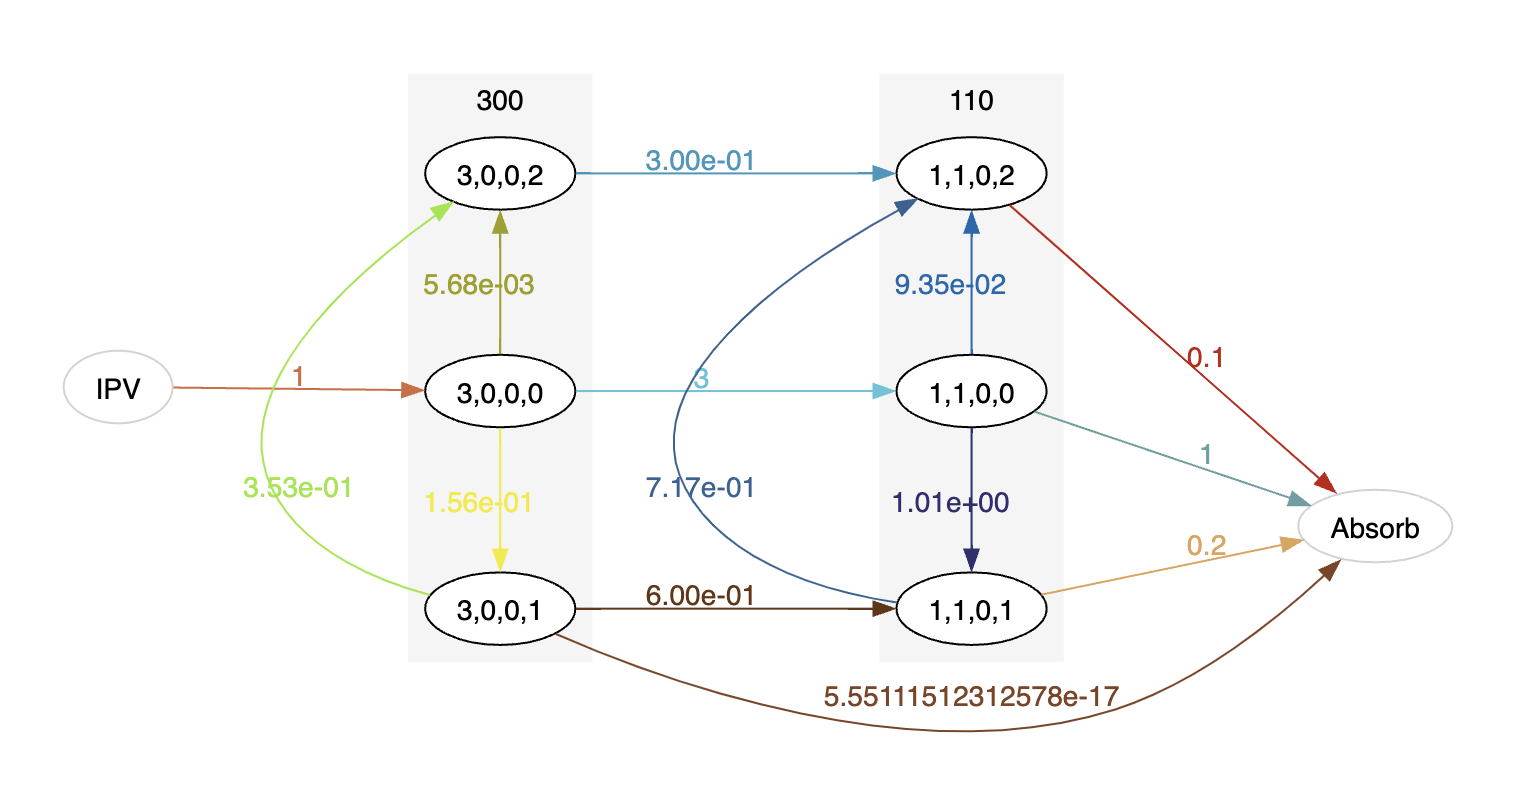

In [134]:
graph_as_matrix(graph)

2,0,0
2,0,3
2,0,4
-1.312634,0.156317,0.156317
0.000000,NaN,NaN
0.000000,0.000000,-0.100000


In [51]:
gam <- graph_as_matrix(graph)
c(length(gam$indices), max(gam$indices)-min(gam$indices)+1)

[1] 3 5

In [126]:
moments(graph, 5)

[1] 0.4608431 0.4094141 0.5354350 0.9241642 1.9824427

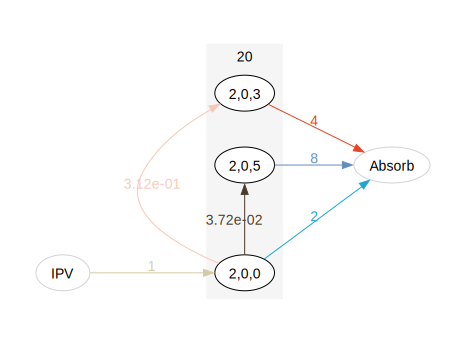

In [127]:
gam <- graph_as_matrix(graph)
plot_graph(gam, subgraphs=TRUE, rainbow=TRUE, size=c(8, 8), align=TRUE,
           fontsize=14, ranksep=1, nodesep=0.5,          
           subgraphfun=function(state) paste(state[-length(state)], collapse=""))
#plot_graph(gam, subgraphs=TRUE, size=c(8, 8))

## Failed attempt to zip graph, collapsing sister states back into graph

In [5]:
# #library(plotly)
# library(ggplot2)
# library(viridis)
# library(grid)
# library(gridExtra)
# library("IRdisplay")

# library(tidyverse)
# library(devtools)
# #remove.packages("ptdalgorithms")
# # devtools::install_github("TobiasRoikjer/PtDAlgorithms")
# library(ptdalgorithms)

# source("plot_functions.R")

# theme_set(theme_bw())

In [6]:
# n_samples = 4;

# Rcpp::sourceCpp("./timeinhom-kingman.cpp")
# graph <- init_kingman_graph(n_samples)
# graph <- fill_kingman_graph(graph, n_samples, 1, 1)
# nr_vertices <- vertices_length(graph)
# graph <- add_kingman_epoque(n_samples, graph, 1, 10, nr_vertices)
# # nr_vertices <- vertices_length(graph)
# # graph <- add_kingman_epoque(n_samples, graph, 2, 10, nr_vertices)
# plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, size=c(8, 8))
# print(moments(graph, 5))

In [7]:
# graph <- zip_graph(graph)
# plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, size=c(8, 8))
# print(moments(graph, 5))

## Falied attempt to zip graphs without first adding sister-states

Trying to zip graphs without add sister states frist and then remove them.

Turns out the problem becomes that I need to keep track of the accumulated probability of being in the sister state and I cannot do that without the the sister states.

In [8]:
# graph <- init_kingman_graph(n_samples)
# graph <- fill_kingman_graph(graph, n_samples, 1, 1)
# #plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, size=c(8, 9))

In [9]:
# other_graph <- init_kingman_graph(n_samples)
# other_graph <- fill_kingman_graph(other_graph, n_samples, 10, 1)
# #plot_graph(graph_as_matrix(other_graph), fontsize=14, ranksep=1, nodesep=0.25, size=c(8, 8))

In [10]:
# graph <- fast_zip_graph(graph, other_graph, 1)
# plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, size=c(8, 8))

# moments(graph, 5)

In [11]:
# graph <- generate_kingman_graph(n_samples, n_samples+1)
# plot_graph(graph_as_matrix(graph), fontsize=14, ranksep=1, nodesep=0.25, size=c(10, 10))

In [12]:
# graph_as_matrix(graph)

In [13]:

# // // [[Rcpp::export]]
# // SEXP zip_graph(SEXP graph) {

# //     // TODO: there should be a check to make sure the graph is 
# //     // toplogically sorted. Maybe it is not if made from a matrix.
    
# //     Rcpp::XPtr<Graph> graphcpp(graph);
# //     struct ptd_graph *ptd_graph = graphcpp->c_graph();

# //     int *state = (int *) calloc(ptd_graph->state_length, sizeof(int));
# //     int *child_state = (int *) calloc(ptd_graph->state_length, sizeof(int));

# //     struct ptd_vertex *vertex;      
# //     struct ptd_vertex *sister_vertex;
# //     struct ptd_edge *edge;       
# //     struct ptd_edge *sister_edge;
# //     struct ptd_edge *edge_from_vertex;
# //     struct ptd_edge *edge_from_sister_vertex;

# //     // loop states
# //     for (int i=0; i<ptd_graph->vertices_length; i++) {
# //         vertex = ptd_graph->vertices[i];
# //         state = vertex->state;

# //         if (state[ptd_graph->state_length-1] != 0) {
# //             // skip state not epoque zero
# //             continue;
# //         }

# //         fprintf(stderr, "\nstate:\t");
# //         print_state(state, ptd_graph->state_length);
        
# //         // find edge to sister state
# //         int sister_edge_index = -1;
# //         for (size_t j = 0; j < vertex->edges_length; ++j) {
# //             edge = vertex->edges[j];
# //             child_state = edge->to->state;
# //             for (int k=0; k<ptd_graph->state_length-1; k++) {
# //                 if (state[k] != child_state[k]) {
# //                     sister_edge_index = -1;
# //                     break;
# //                 } else {
# //                    sister_edge_index = j; 
# //                 }
# //             }
# //             if (sister_edge_index > -1) {
# //                 break;
# //             }
# //         }
# //         if (sister_edge_index == -1) {   
# //             continue;
# //         }
# //         // found sister state

# //         sister_edge = vertex->edges[sister_edge_index];
# //         sister_vertex = sister_edge->to;
        
# //         fprintf(stderr, "sister:\t");
# //         print_state(sister_vertex->state, ptd_graph->state_length);

# //         // loop edges from vertex (except edge to sister state)
# //         // assuming edges out of state and sister_state are ordered the same way...
# //         int nr_edges = vertex->edges_length;
# //         for (size_t j = 0; j < nr_edges; ++j) {
# //             if (j == sister_edge_index) {
# //                 continue;
# //             }
# //             edge_from_vertex = vertex->edges[j];
# //             edge_from_sister_vertex = sister_vertex->edges[j];

# //             // hack to disregard strange unspecivied edges with very low prob (bug?)
# //             if (edge->weight < 1e-13) {
# //                 continue;
# //             }


# //             // add weight of sister_vertex edge from shared parent
# //             // to weight of vertex edge from shares parent 
            
# //             // make new edge
# //             double a = edge_from_vertex->weight;
# //             double b = sister_edge->weight;
# //             double c = edge_from_sister_vertex->weight;
# //             double weight_new_edge = b/(a+b) * c;

# //             // fprintf(stderr, "%d %f %f %f\n", j, a, b, c);
            
# //             ptd_graph_add_edge(vertex, 
# //                 edge_from_sister_vertex->to, 
# //                 weight_new_edge);

# //             fprintf(stderr, "to:\t");
# //             print_state(edge_from_sister_vertex->to->state, ptd_graph->state_length);


            
# //             edge_from_sister_vertex->weight = 0;

# //             // save sister index to be removed from graph at the end:
# //             // sister_vertex->index 

# //         }
# //         // if (sister_edge_index > -1) {
# //         //     vertex->edges[sister_edge_index]->weight = 0;
# //         //    // sister_edge->weight = 0; 
# //         // }
# //     }

# //     // delete sister nodes
    
# //   // free(state);
# //   // free(child_state);

# //     return Rcpp::XPtr<Graph>(graph);
# // }

# // // [[Rcpp::export]]
# // SEXP fast_zip_graph(SEXP graph1, SEXP graph2, double t) {

# //     Rcpp::XPtr<Graph> graphcpp1(graph1);
# //     struct ptd_graph *kingman_graph1 = graphcpp1->c_graph();

# //     Rcpp::XPtr<Graph> graphcpp2(graph2);
# //     struct ptd_graph *kingman_graph2 = graphcpp2->c_graph();

# //     int nr_states = kingman_graph1->vertices_length;

# //     std::vector<double> stop_probs = graphcpp1->stop_probability(t);
# //     std::vector<double> acum_visit = graphcpp1->accumulated_visiting_time(t);

# //     double *edge_trans = (double *) calloc(nr_states, sizeof(double));
# //     for (int i=0; i<kingman_graph1->vertices_length; i++) {
# //         edge_trans[i] = stop_probs[i] / acum_visit[i];
# //     }

# //     // assuming vertices and edges are ordered the same way...
# //     for (size_t i = 1; i < nr_states-1; ++i) {
# //         if (std::isnan(edge_trans[i])) {
# //             continue;
# //         }
# //         struct ptd_vertex *vertex1 = kingman_graph1->vertices[i];
# //         struct ptd_vertex *vertex2 = kingman_graph2->vertices[i];

# //         for (size_t j = 0; j < vertex1->edges_length; ++j) {
# //             struct ptd_edge *edge1 = vertex1->edges[j];
# //             struct ptd_edge *edge2 = vertex2->edges[j];

# //             // hack to disregard strange unspecivied edges with very low prob (bug?)
# //             if (edge1->weight < 10e-13) {
# //                 continue;
# //             }
            
# //             double a = edge1->weight;
# //             double b = edge_trans[i];
# //             double c = edge2->weight;

# //             edge1->weight = a/(a+b) + b/(a+b) * c;
            
# //         }
   
# //     }
        
# //     return Rcpp::XPtr<Graph>(graph1);

# // }



In [ ]:


# // // [[Rcpp::export]]
# // SEXP add_kingman_epoque(SEXP graph, int n, double t, double size) {

# //     Rcpp::XPtr<Graph> graphcpp(graph);
# //     struct ptd_graph *kingman_graph = graphcpp->c_graph();
# //     struct ptd_avl_tree *avl_tree = graphcpp->c_avl_tree();

# //     int nr_states = kingman_graph->vertices_length;

# //     std::vector<double> stop_probs = graphcpp->stop_probability(t);
# //     std::vector<double> acum_visit = graphcpp->accumulated_visiting_time(t);

# //     double *edge_trans = (double *) calloc(nr_states, sizeof(double));
# //     for (int i=0; i<kingman_graph->vertices_length; i++) {
# //         edge_trans[i] = stop_probs[i] / acum_visit[i];
# //     }

# //     int *sister_state = (int *) calloc(kingman_graph->state_length, sizeof(int));
# //     for (size_t i = 1; i < nr_states-1; ++i) {

# //         if (std::isnan(edge_trans[i])) {
# //             continue;
# //         }
# //         struct ptd_vertex *vertex = kingman_graph->vertices[i];
# //         memcpy(sister_state, vertex->state, kingman_graph->state_length * sizeof(int));

# //         sister_state[kingman_graph->state_length-1] = nr_states; // to label epoque...
# //         struct ptd_vertex *child = ptd_find_or_create_vertex(kingman_graph, avl_tree, sister_state);
# //         ptd_graph_add_edge(vertex, child, edge_trans[i]);        
# //     }

# //     free(sister_state);

# //       return Rcpp::XPtr<Graph>(
# //         graph
# //           );

# // }


In [ ]:
# /*
#  * Clone or download the code, and include these files in the repository!
#  * Make SURE that the version of the downloaded code is the same as the
#  * installed R library!! Otherwise it may crash randomly.
#  *
#  * The path is currently ../ as we are in the same repository. This path
#  * should be something like [full or relative path to cloned code]/api...
#  */
# #include "./../../PtDAlgorithms/api/c/ptdalgorithms.h"

# /*
# * Including a .c file is very strange usually!
# * But the way Rcpp::sourceCpp links is different from what
# * you would usually expect. Therefore this is by far
# * the easiest way of importing the code.
# */
# #include "./../../PtDAlgorithms/api/cpp/ptdalgorithmscpp.h"
# #include "./../../PtDAlgorithms/src/c/ptdalgorithms.c"

# /* This is the binding layer such that R can invoke this function */
# #include <Rcpp.h>

# /* Basic C libraries */
# #include "stdint.h"
# #include "stdlib.h"

# using namespace std;
# using namespace ptdalgorithms;
# using namespace Rcpp;

# Graph *fill_kingman_graph(ptd_graph *kingman_graph, ptd_avl_tree *avl_tree, int n) {

#   int *state = (int *) calloc(kingman_graph->state_length, sizeof(int));
#   for (int k = 1; k < kingman_graph->vertices_length; k++) {
#     // fprintf(stderr, "%d\n", k);

#     R_CheckUserInterrupt();
#     struct ptd_vertex *vertex = kingman_graph->vertices[k];
#     memcpy(state, vertex->state, kingman_graph->state_length * sizeof(int));

#     for (int i=0; i<kingman_graph->state_length; i++) {
#          fprintf(stderr, "%d ", state[i]);
#     }
#     fprintf(stderr, "\n");
      
#     for (int i = 0; i <= n-1; ++i) {
#       for (int j = i; j <= n-1; ++j) {
#         double weight;
        
#         if (i == j) {
#           if (state[i] < 2) {
#             continue;
#           }
          
#           weight = state[i] * (state[i] - 1) / 2;
#         } else {
#           if (state[i] < 1 || state[j] < 1) {
#             continue;
#           }
          
#           weight = state[i] * state[j];
#         }

#         int new_index = i + j + 2 - 1;
        
#         if (new_index > n-1) {
#           new_index = n-1;
#         }
        
#         state[i]--;
#         state[j]--;
#         state[new_index]++;
        
#         struct ptd_vertex *child = ptd_find_or_create_vertex(kingman_graph, avl_tree, state);
        
#         state[i]++;
#         state[j]++;
#         state[new_index]--;
        
#         // ptd_graph_add_edge(vertex, child, weight);
#         double *scalars = (double *) calloc(1, sizeof(double));
#         scalars[0] = weight;
#         ptd_graph_add_edge_parameterized(vertex, child, weight, scalars);
#       }
#     }
#   }
#   free(state);
  
#     // return Rcpp::XPtr<Graph>(graph);

#     return new Graph(kingman_graph, avl_tree);
 
# }

# // [[Rcpp::export]]
# SEXP kingman_graph(int n) {

#   int state_length = n + 1;
#   struct ptd_graph *kingman_graph = ptd_graph_create(state_length);
#   struct ptd_avl_tree *avl_tree = ptd_avl_tree_create(state_length);
#   int *initial_state = (int *) calloc(kingman_graph->state_length, sizeof(int));
#   initial_state[0] = n;
#   ptd_graph_add_edge(
#     kingman_graph->starting_vertex,
#     ptd_find_or_create_vertex(kingman_graph, avl_tree, initial_state),
#     1
#   );
#   free(initial_state);

#   return Rcpp::XPtr<Graph>(
#       fill_kingman_graph(kingman_graph, avl_tree, n)
#       );
# }

# // [[Rcpp::export]]
# void add_epoque(SEXP graph, double t, std::vector<double> scalars) {

#     Rcpp::XPtr<Graph> graphcpp(graph);
#     struct ptd_graph *c_graph = graphcpp->c_graph();
#     struct ptd_avl_tree *avl_tree = graphcpp->c_avl_tree();

#     // compute edge_trans
#     std::vector<double> stop_probs = graphcpp->stop_probability(t);
#     std::vector<double> acum_visit = graphcpp->accumulated_visiting_time(t);
#     double *edge_trans = (double *) calloc(c_graph->vertices_length, sizeof(double));
#     for (int i=0; i<c_graph->vertices_length; i++) {
#         edge_trans[i] = stop_probs[i] / acum_visit[i];
#     }
#     // epoque label for states to be added
#     int eqoque_label = c_graph->vertices_length;

#     // TODO: FIND MORE ELEGANT WAY TO LOOP OVER STATES TO ADD INSTEAD OF CLONING THE GRAPH
#     // (FOR NOW IT SOLVES THE PROBLEM OF INDEXING VERTICES WHILE ADDING MORE INDICES TO THE GRAPH)
#     // clone graph
#     ptd_clone_res cloned_graph = ptd_clone_graph(c_graph, avl_tree);
#     struct ptd_graph *cloned_c_graph = cloned_graph.graph;
#     struct ptd_avl_tree *cloned_avl_tree = cloned_graph.avl_tree;
#     // number of cloned states
#     int nr_cloned_states = cloned_c_graph->vertices_length;

#     // update weights of cloned graph
#     ptd_graph_update_weight_parameterized(cloned_c_graph, &scalars[0], scalars.size());

    
#     // assuming edges in nodes are sorted the same way...
#     // add a copy of each vertex to the graph
#     int *state = (int *) calloc(c_graph->state_length, sizeof(int));
#     double *edge_state = (double *) calloc(scalars.size(), sizeof(double));    
#     for (size_t i = 0; i < nr_cloned_states; ++i) {

#         // get orig vertex
#         struct ptd_vertex *vertex = c_graph->vertices[i];

#         // get corresponding vertex from cloned graph
#         struct ptd_vertex *cloned_vertex = cloned_c_graph->vertices[i];

#         // skip starting and absorbing vertices
#         if (i == c_graph->starting_vertex->index) {
#             // starting vertex
#             continue;
#         }
#         if (vertex->edges_length == 0) {
#             // absorbing state
#             continue;
#         }

#         // make the state of the sister vertex
#         memcpy(state, vertex->state, c_graph->state_length * sizeof(int));
#         // to label epoque...
#         state[c_graph->state_length-1] = eqoque_label;

#         // add copy of cloned vertex to graph
#         struct ptd_vertex *sister_vertex = ptd_find_or_create_vertex(c_graph, avl_tree, state);
        
#         // add edges
#         for (size_t j = 0; j < vertex->edges_length; ++j) {

#             // get edge in orig graph
#             struct ptd_edge_parameterized *edge = ((struct ptd_edge_parameterized *) vertex->edges[j]);

#             // get to-vertex in orig graph
#             struct ptd_vertex *to_vertex = ptd_find_or_create_vertex(c_graph, avl_tree, edge->to->state);


#             // only add edges connecting same-epoque states
#             if (vertex->state[c_graph->state_length-1] != to_vertex->state[c_graph->state_length-1]) {
#                 continue;
#             }
#             // add copy of that vertex to graph
#             memcpy(state, to_vertex->state, c_graph->state_length * sizeof(int));
#             // to label epoque...
#             state[c_graph->state_length-1] = eqoque_label;
#             struct ptd_vertex *sister_to_vertex = ptd_find_or_create_vertex(c_graph, avl_tree, state);
            
#             memcpy(edge_state, edge->state, ((int) scalars.size()) * sizeof(double));

#             // add edge between sister vertices
#             double weight = 0;
#             for (size_t k = 0; k < scalars.size(); ++k) {
#                 weight += scalars[k] * ((struct ptd_edge_parameterized *) vertex->edges[j])->state[k];
#             }
#             ptd_graph_add_edge_parameterized(sister_vertex, sister_to_vertex, weight, edge_state);         
#         }
#         // add edge_trans edge
#         memcpy(edge_state, &scalars[0], ((int) scalars.size()) * sizeof(double));
#         ptd_graph_add_edge_parameterized(vertex, sister_vertex, edge_trans[i], edge_state);
#     }
#     ptd_validate_graph(c_graph);
#     ptd_notify_change(c_graph);  
# }


# void print_state(int *state, int l) {

#     for (int i=0; i<l; i++) {
#          fprintf(stderr, "%d ", state[i]);
#     }
#     fprintf(stderr, "\n");
# }

# // [[Rcpp::export]]
# int number_of_edges(SEXP phase_type_graph) {
#   Rcpp::XPtr<Graph> graphcpp(phase_type_graph);
#   ptd_graph *graph = graphcpp->c_graph();
#   int nedges = 0;
  
#   for (size_t k = 0; k < graph->vertices_length; ++k) {
#     nedges += graph->vertices[k]->edges_length;
#   }
  
#   return nedges;
# }